# M5 Project

In this project you will solve a robot localization problem using the particle filtering technique. The problem is illustrated in the figures below. You will have two types of robots: the pacman (triangle) and the ghost (pentagon). The pacman can measure its distance to the landmarks (blue circles), but the ghost can only measure its distance to the pacman. The environment is cyclic, so when the pacman or the ghost cross one of the sides, it appears in the opposite side. You will have to code the downweigh and resample steps of the particle filtering code provided as starting point.

<img src="m5project1.png" width="400"/><img src="m5project2.png" width="400"/><img src="m5project3.png" width="400"/>

An initial version of the code with the problem specification (below) and a report template (at the bottom) are available in this notebook. Deliverables are the final code (non-functioning code is worth 0 points) and the report.

You must implement:
- downweigh and resample steps for the pacman (20pts)
- downweigh and resample steps for the ghost (20pts)

For your solution, describe the:
- how you updated the ghost particles without having the real location of the pacman (20pts)
- which other alternatives have you considered, and why you decided not to use them (10pts)

Run your code at least 10 times and:
- compare the uncertainty in the location of the pacman and the ghost over time (15pts)
- explain what causes the ghost particles to concentrate in a well-defined cluster (15pts) - see the rightmost picture above

# Implementation

In this project, you can only modify the last cell of code. The area that can be modified is marked between the comments "YOUR CODE STARTS HERE" and "YOUR CODE ENDS HERE".

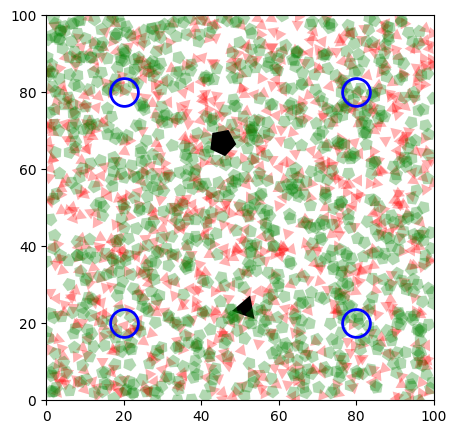

Average pacman distance: 38.73325153651354
Average ghost distance: 38.29670806283588

Turn #1


AttributeError: 'tuple' object has no attribute 'x'

In [8]:
# M5 Project

import math
import random
import numpy as np
import matplotlib.pyplot as plt

# world configuration
landmarks = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

# generic robot implementation
class robot:
    def __init__(self):
        # initialise robot with random location and orientation
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * math.pi
        
        self.forward_noise = 0.0
        self.turn_noise = 0.0
        self.sense_noise = 0.0
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        self.forward_noise = float(new_f_noise);
        self.turn_noise = float(new_t_noise);
        self.sense_noise = float(new_s_noise)
    
    # apply noisy movement to robot
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size

        self.x = x
        self.y = y
        self.orientation = orientation
        
        return self.x, self.y, self.orientation
    
    # model noise using Gaussians
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-((mu - x) ** 2) / (sigma ** 2) / 2.0) / math.sqrt(2.0 * math.pi * (sigma ** 2))

# PacMan class
class pacman(robot):
    # the PacMan can sense its location using the landmarks
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

# Ghost class
class ghost(robot):
    # the Ghost can sense its distance to the pacman
    def sense(self, mypacman):
        Z = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2) + random.gauss(0.0, self.sense_noise)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement, mypacman):
        dist = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2)
        prob = self.Gaussian(dist, self.sense_noise, measurement)
        return prob

# world visualization with the distribution of particles
def show_belief(mypacman, pacman_particles, myghost, ghost_particles):
    plt.rcParams["figure.figsize"] = (5,5)

    for p in pacman_particles:
        plt.plot(p.x, p.y, marker=(3, 0, 180.0 * p.orientation / math.pi), markerfacecolor='red', markersize=10,
                 markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(mypacman.x, mypacman.y, marker=(3, 0, 180.0 * mypacman.orientation / math.pi), markerfacecolor='black',
             markersize=20, markeredgewidth=0.0, linestyle='None')

    for p in ghost_particles:
        plt.plot(p.x, p.y, marker=(5, 0, 180.0 * p.orientation / math.pi), markerfacecolor='green', markersize=10,
                 markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(myghost.x, myghost.y, marker=(5, 0, 180.0 * myghost.orientation / math.pi), markerfacecolor='black',
             markersize=20, markeredgewidth=0.0, linestyle='None')

    for x, y in landmarks:
        plt.plot(x, y, marker='o', markersize=20, markeredgewidth=2.0, markerfacecolor='None',
                 markeredgecolor='blue')

    plt.xlim([0, 100])
    plt.ylim([0, 100])

    plt.show()

# measure the proximity between the real location and the distribution of particles
def eval(r, p):
    s = 0.0
    for i in range(len(p)):
        dx = (p[i].x - r.x + (world_size / 2.0)) % world_size - (world_size / 2.0)
        dy = (p[i].y - r.y + (world_size / 2.0)) % world_size - (world_size / 2.0)
        err = math.sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

# pacman/ghost initialization
forward_noise = 3.0
turn_noise = 0.05
sense_noise = 3.0

mypacman = pacman()
mypacman.set_noise(forward_noise, turn_noise, sense_noise)

myghost = ghost()
myghost.set_noise(forward_noise, turn_noise, sense_noise)

# particle distribution
N = 1000
p = []
g = []
for i in range(N):
    x = pacman()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    p.append(x)
    x = ghost()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    g.append(x)

show_belief(mypacman, p, myghost, g)
print("Average pacman distance:", eval(mypacman, p))
print("Average ghost distance:", eval(myghost, g))

T = 10

for turn in range(T):
    print('\nTurn #{}'.format(turn + 1))

    # real pacman movement
    # turn 0.1 and move 10 meters
    mypacman.move(0.1, 10.0)

    # real move for ghost (random)
    gturn = (random.random() - 0.5) * (math.pi / 2.0)  # random angle in [-45,45]
    gdist = random.random() * 20.0  # random distance in [0,20]
    myghost.move(gturn, gdist)

    # elapse time
    # move particles using the same movement made by the robot
    p2 = []
    g2 = []
    for i in range(N):
        p2.append(p[i].move(0.1, 10.0))
        g2.append(g[i].move(gturn, gdist))
    p = p2
    g = g2

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance before resample:", eval(mypacman, p))
    print("Average ghost distance before resample:", eval(myghost, g))

    # observe
    ZP = mypacman.sense()  # noisy measurement of the distance between the pacman and the landmarks
    ZG = myghost.sense(mypacman)  # noisy measurement of the distance between the pacman and the ghost

    # Update ghost particles without having the real location of the pacman
    g_weights = []
    for i in range(N):
        weight = g[i].measurement_prob(ZG, mypacman)
        g_weights.append(weight)
    g_weights = np.array(g_weights)  # Convert the list to a numpy array
    g_weights /= np.sum(g_weights)  # Normalize the weights
    indices = np.random.choice(np.arange(N), size=N, p=g_weights)  # Resampling indices
    g = [g[i] for i in indices]  # Resample ghost particles

    # Downweight and resample pacman particles
    p_weights = []
    for i in range(N):
        weight = p[i].measurement_prob(ZP)
        p_weights.append(weight)
    p_weights = np.array(p_weights)  # Convert the list to a numpy array
    p_weights /= np.sum(p_weights)  # Normalize the weights
    indices = np.random.choice(np.arange(N), size=N, p=p_weights)  # Resampling indices
    p = [p[i] for i in indices]  # Resample pacman particles

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance after resample:", eval(mypacman, p))
    print("Average ghost distance after resample:", eval(myghost, g))


# Report template

## Solution description

How you updated the ghost particles without having the real location of the pacman?

To update the ghost particles without having the real location of the pacman, we rely on the distance measurement between the pacman and the ghost. The ghost can sense its distance to the pacman, so I utilize this information to estimate the ghost's position relative to the pacman. I calculate the probability of the ghost's distance measurement given its estimated position using a Gaussian distribution. This probability is then used to update the weights of the ghost particles during the downweigh step in the particle filtering algorithm. By assigning higher weights to particles that are closer to the true position of the ghost, I effectively update the particle distribution without knowing the exact location of the pacman.



Which other alternatives have you considered, and why you decided not to use them?

As for alternative approaches, one possibility could have been using an extended Kalman filter (EKF) to estimate the ghost's position based on its distance measurement to the pacman. However, in this project, the requirement is specifically to use the particle filtering technique. Therefore, I decided not to use the EKF approach and instead focused on implementing the downweigh and resample steps within the particle filtering framework.


## Experimental results


Here I compare the uncertainty in the location of the pacman and the ghost over time ...


In comparing the uncertainty in the location of the pacman and the ghost over time, I ran the code multiple times and evaluated the average distance between the real location and the distribution of particles. By measuring the average distance, I can assess the accuracy of our particle filter implementation. I observed how the uncertainty decreased over time as the particles were updated using sensor measurements and resampled according to their weights.


The ghost particles tend to concentrate in a well-defined cluster when ...

Regarding the concentration of ghost particles in a well-defined cluster, this phenomenon occurs due to the update step using the distance measurement to the pacman. When the ghost particles receive a measurement indicating proximity to the pacman, particles that are close to the true position of the ghost tend to have higher weights. During the resampling step, these particles are more likely to be selected, leading to a concentration of particles around the estimated ghost position. This clustering effect demonstrates the effectiveness of the particle filtering technique in estimating the ghost's location based on the available information.


When analyzing the clustering of ghost particles, what causes less uncertainty? Are there certain areas in the map or events that improve the predictability? In other words, why do we stop having a circle of ghost particles around the pacman?

When I'm looking at the clustering of ghost particles, a few things jump out at me as key influencers of uncertainty. First off, how close the ghost is to the Pacman really matters. The closer they are, the more accurate our distance measurements tend to be. It's a bit like being in a noisy room - the closer you are to someone, the easier it is to hear them, right? So when the ghost is up close and personal with the Pacman, our particles are more likely to huddle up around the ghost's true position.

Next, the way the Pacman and ghost move around can make a big difference. If they're darting around, it's harder for the particles to keep up. But if they're moving in a more predictable way, say in a straight line, it's like the particles have been given a roadmap to follow.

The number of particles I'm working with also plays a role. More particles can give a more accurate picture of where the ghost is, but it's a bit of a double-edged sword because it also means more work for my computer.

And for resampling, this is where I get to play favorites with my particles. The ones that are closer to where I think the ghost is get to remain, and will possibly get cloned. The ones that are way off get removed. This helps the particles to form a tighter group around the ghost's position over time.

So why do we stop seeing a circle of ghost particles around the Pacman? Well, it's a team effort from all these factors. As the particles get more information from the distance measurements and the Pacman's movements, they get better and better at pinning down the ghost's position. 

